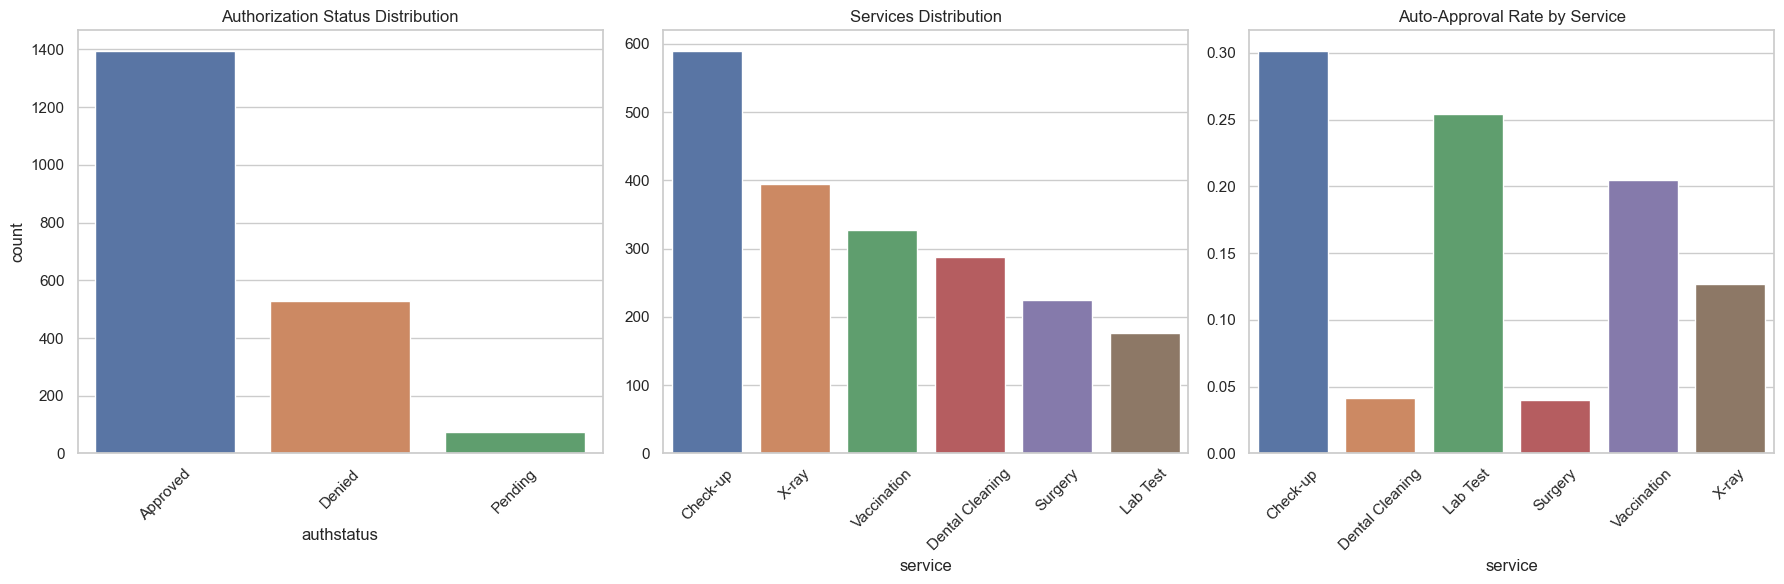

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                   GridSearchCV, StratifiedKFold, learning_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                           precision_recall_curve, auc, average_precision_score, 
                           f1_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set modern style for visualizations
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load the data
claims_data = pd.read_csv('DS Case Study - Claims.csv')
prior_auth_data = pd.read_csv('DS Case Study - PriorAuth.csv')

# Convert dates to datetime
prior_auth_data['submission_date'] = pd.to_datetime(prior_auth_data['submission_date'])
claims_data['Claim Date'] = pd.to_datetime(claims_data['Claim Date'])

# Basic exploratory analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Authorization Status Distribution
sns.countplot(data=prior_auth_data, x='authstatus', ax=axes[0])
axes[0].set_title('Authorization Status Distribution')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot 2: Services Distribution
service_counts = prior_auth_data['service'].value_counts()
sns.barplot(x=service_counts.index, y=service_counts.values, ax=axes[1])
axes[1].set_title('Services Distribution')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Plot 3: Auto-Approval Rate by Service
auto_approve_rate = prior_auth_data.groupby('service')['auto_approved'].mean()
sns.barplot(x=auto_approve_rate.index, y=auto_approve_rate.values, ax=axes[2])
axes[2].set_title('Auto-Approval Rate by Service')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Feature engineering function
def create_pet_features(auth_row, claims_history):
    pet_id = auth_row['pet_id']
    auth_date = auth_row['submission_date']
    
    # Get historical claims - using correct column name
    pet_claims = claims_history[
        (claims_history['Pet Id'] == pet_id) & 
        (claims_history['Claim Date'] < auth_date)
    ]
    
    # Calculate basic features
    features = {
        'prior_claims_count': len(pet_claims),
        'total_claims_amount': pet_claims['Amount Paid'].sum(),
        'unique_procedures': len(pet_claims['Claim Type'].unique()),
        'avg_claim_amount': pet_claims['Amount Paid'].mean() if len(pet_claims) > 0 else 0,
        'days_since_last_claim': (auth_date - pet_claims['Claim Date'].max()).days if len(pet_claims) > 0 else 365
    }
    
    # Add procedure type counts
    for proc_type in claims_history['Claim Type'].unique():
        count = len(pet_claims[pet_claims['Claim Type'] == proc_type])
        features[f'prior_{proc_type.lower().replace("-", "_").replace(" ", "_")}_count'] = count
    
    return features

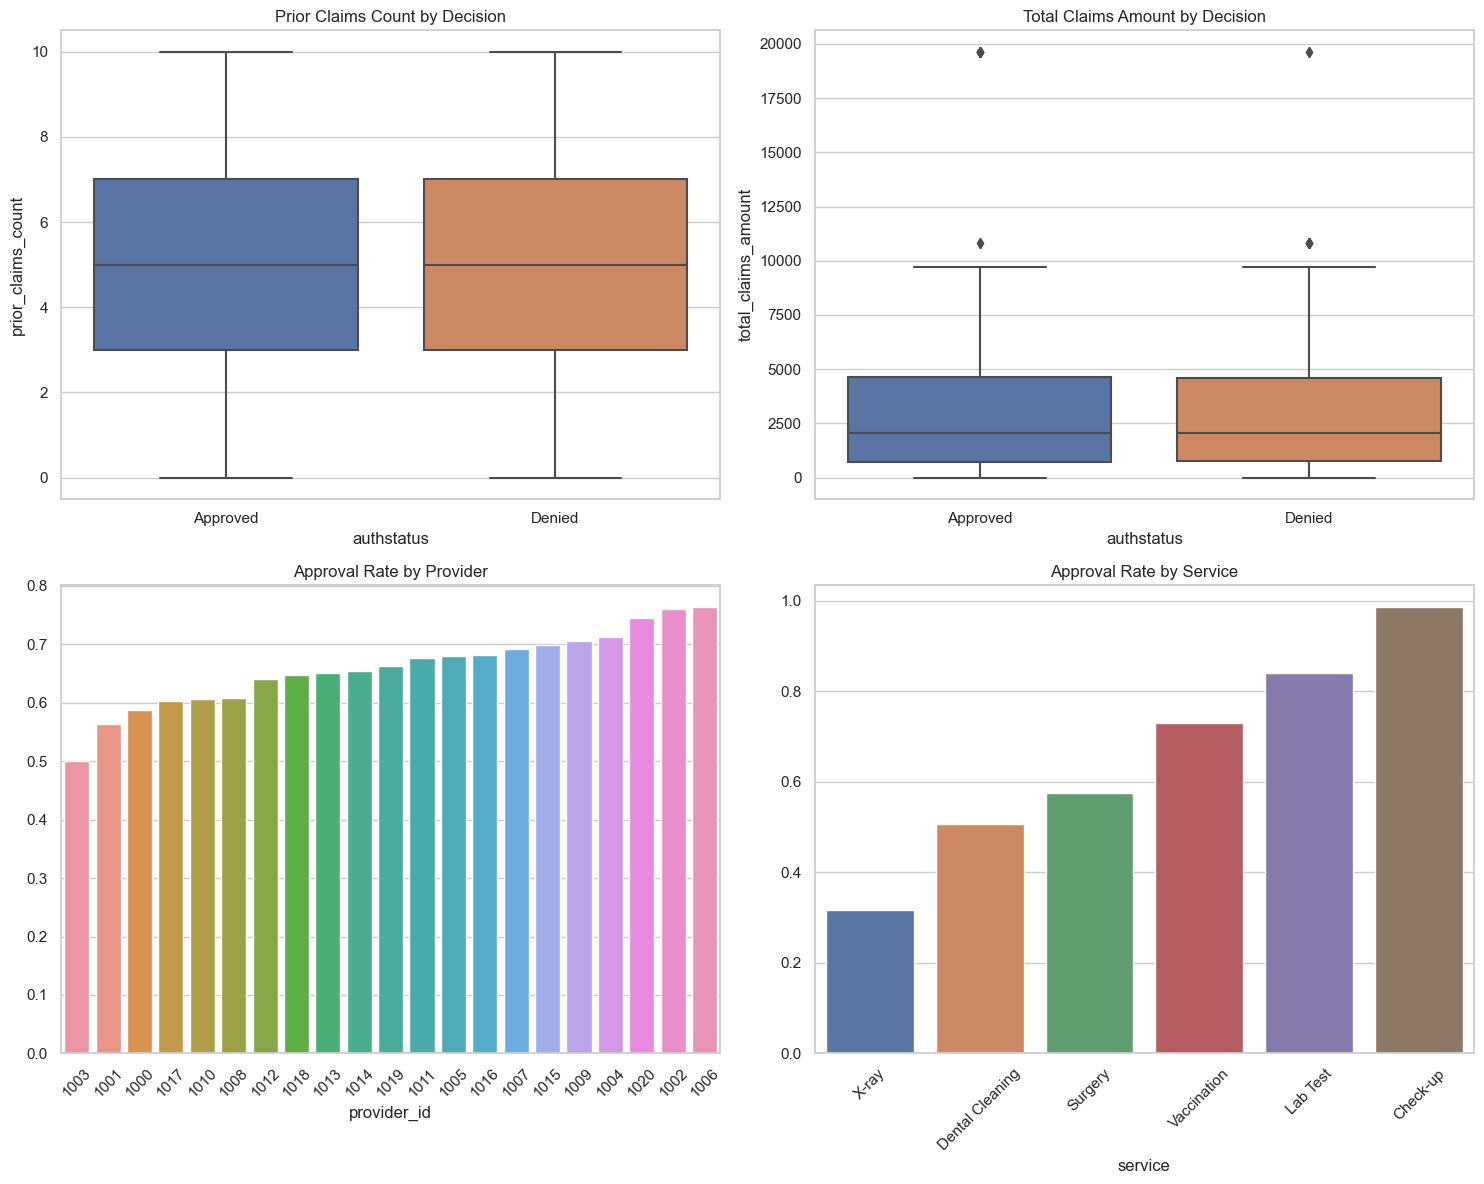

In [5]:
# Generate features
feature_list = []
for _, auth in prior_auth_data.iterrows():
    features = create_pet_features(auth, claims_data)
    features['auth_id'] = auth['id']
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)

# Merge features with authorization data
model_df = pd.merge(prior_auth_data, features_df, left_on='id', right_on='auth_id', how='left')

# Filter for modeling
model_df = model_df[
    (model_df['auto_approved'] == False) & 
    (model_df['authstatus'].isin(['Approved', 'Denied']))
]

# Create feature distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Prior Claims Distribution
sns.boxplot(data=model_df, x='authstatus', y='prior_claims_count', ax=axes[0,0])
axes[0,0].set_title('Prior Claims Count by Decision')

# Plot 2: Claims Amount Distribution
sns.boxplot(data=model_df, x='authstatus', y='total_claims_amount', ax=axes[0,1])
axes[0,1].set_title('Total Claims Amount by Decision')

# Plot 3: Provider Approval Rates
provider_approval = model_df.groupby('provider_id')['authstatus'].apply(
    lambda x: (x == 'Approved').mean()
).sort_values()
sns.barplot(x=provider_approval.index.astype(str), y=provider_approval.values, ax=axes[1,0])
axes[1,0].set_title('Approval Rate by Provider')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Service Approval Rates
service_approval = model_df.groupby('service')['authstatus'].apply(
    lambda x: (x == 'Approved').mean()
).sort_values()
sns.barplot(x=service_approval.index, y=service_approval.values, ax=axes[1,1])
axes[1,1].set_title('Approval Rate by Service')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Prepare data for modeling
le = LabelEncoder()
model_df['authstatus_encoded'] = le.fit_transform(model_df['authstatus'])
model_df['service_encoded'] = le.fit_transform(model_df['service'])

# Select features for modeling
feature_columns = [
    'service_encoded', 'prior_claims_count', 'total_claims_amount',
    'unique_procedures', 'avg_claim_amount', 'days_since_last_claim'
]

X = model_df[feature_columns]
y = model_df['authstatus_encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define model evaluation functions
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.show()

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1)
    
    plt.ylabel('Score')
    plt.xlabel('Training Examples')
    plt.title(f'Learning Curves for {title}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tuning Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Tuning Decision Tree...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


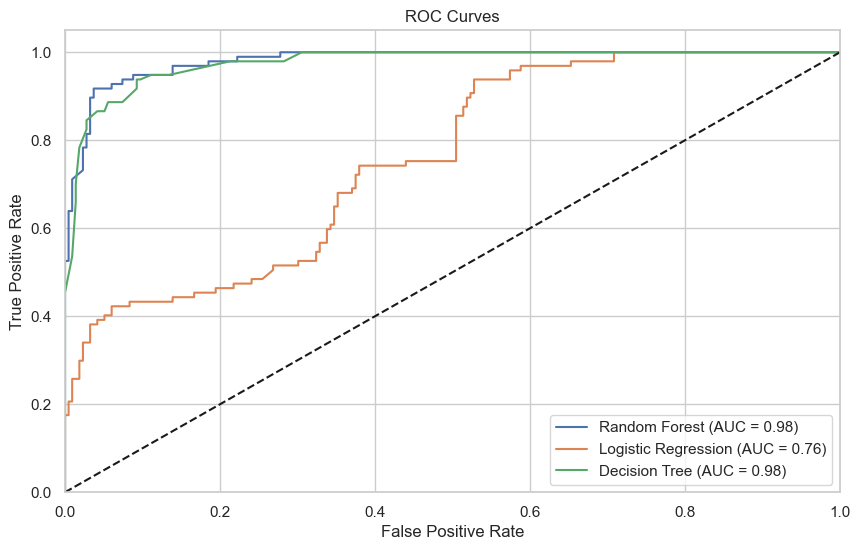

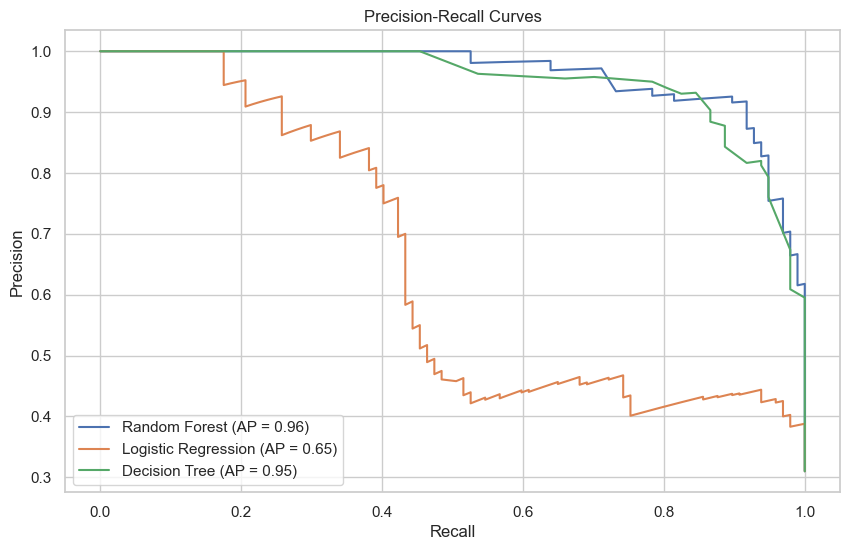

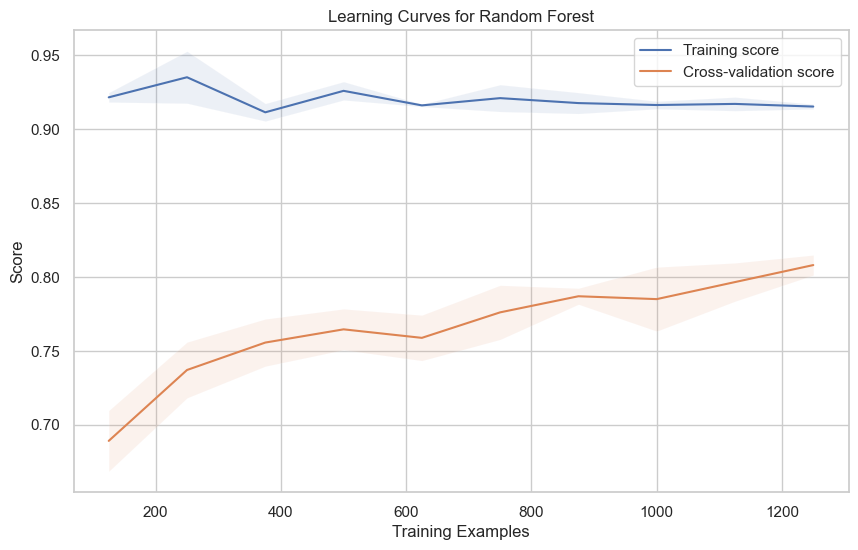

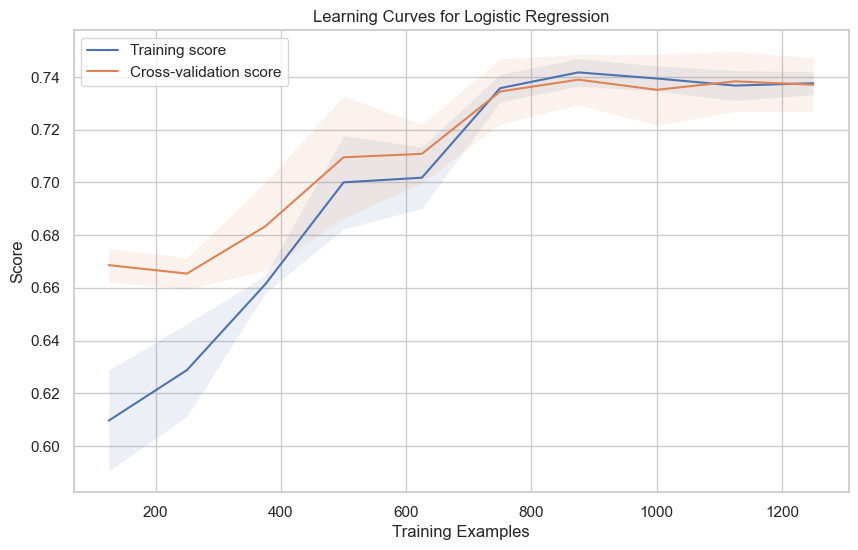

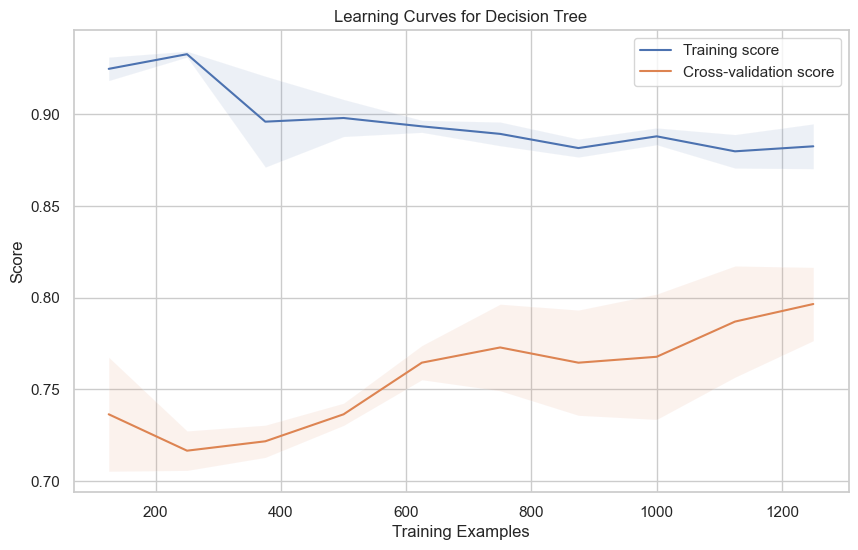


Comprehensive Model Evaluation Results:

Random Forest:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Cross-validation Score: 0.799

Test Set Metrics:
Accuracy: 0.946
F1 Score: 0.911
ROC AUC: 0.981
Average Precision: 0.961

Feature Importance:
service_encoded          0.496063
days_since_last_claim    0.139183
avg_claim_amount         0.126543
total_claims_amount      0.115648
prior_claims_count       0.072031
unique_procedures        0.050533
dtype: float64

Logistic Regression:
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation Score: 0.738

Test Set Metrics:
Accuracy: 0.776
F1 Score: 0.539
ROC AUC: 0.757
Average Precision: 0.650

Decision Tree:
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Cross-validation Score: 0.802

Test Set Metrics:
Accuracy: 0.927
F1 Score: 0.882
ROC AUC: 0.976
Average Precision: 0.947

Feature Importance:
servic

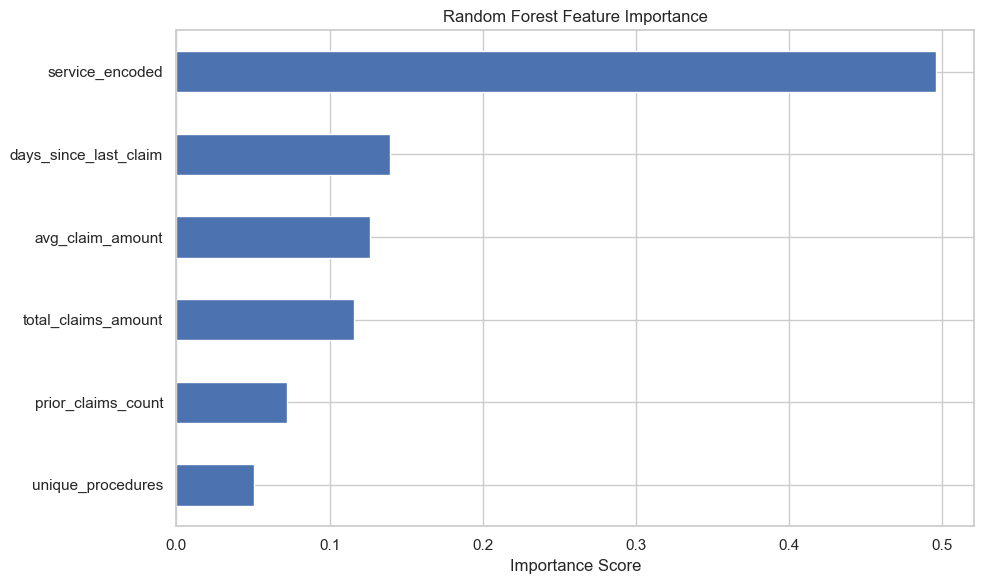


Model Training and Evaluation Complete!

Recommendations based on results:
1. Best performing model: Decision Tree
2. Best cross-validation accuracy: 0.802
3. Most important features (Random Forest):
   - service_encoded: 0.496
   - days_since_last_claim: 0.139
   - avg_claim_amount: 0.127


In [6]:
# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
}

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Perform cross-validation and hyperparameter tuning
cv_results = {}
best_models = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTuning {name}...")
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        model, param_grids[name], cv=skf, 
        scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_scaled, y)
    
    # Store results
    cv_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }
    
    # Store best model
    best_models[name] = grid_search.best_estimator_

# Plot model comparison visualizations
# ROC Curves
plot_roc_curves(best_models, X_test, y_test)

# Precision-Recall Curves
plot_precision_recall_curves(best_models, X_test, y_test)

# Learning Curves for each model
for name, model in best_models.items():
    plot_learning_curves(model, X_scaled, y, name)

# Calculate and print comprehensive metrics
print("\nComprehensive Model Evaluation Results:")
for name, model in best_models.items():
    print(f"\n{name}:")
    print("Best Parameters:", cv_results[name]['best_params'])
    print(f"Cross-validation Score: {cv_results[name]['best_score']:.3f}")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    print("\nTest Set Metrics:")
    print(f"Accuracy: {model.score(X_test, y_test):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {auc(roc_curve(y_test, y_prob)[0], roc_curve(y_test, y_prob)[1]):.3f}")
    print(f"Average Precision: {average_precision_score(y_test, y_prob):.3f}")
    
    # Print feature importance for applicable models
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(
            model.feature_importances_, 
            index=feature_columns
        ).sort_values(ascending=False)
        print("\nFeature Importance:")
        print(importances)

# Create feature importance visualization for Random Forest
if 'Random Forest' in best_models:
    plt.figure(figsize=(10, 6))
    importances = pd.Series(
        best_models['Random Forest'].feature_importances_,
        index=feature_columns
    ).sort_values()
    
    importances.plot(kind='barh')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

# Print final summary
print("\nModel Training and Evaluation Complete!")
print("\nRecommendations based on results:")
best_model_name = max(cv_results, key=lambda k: cv_results[k]['best_score'])
print(f"1. Best performing model: {best_model_name}")
print(f"2. Best cross-validation accuracy: {cv_results[best_model_name]['best_score']:.3f}")
print("3. Most important features (Random Forest):")
if 'Random Forest' in best_models and hasattr(best_models['Random Forest'], 'feature_importances_'):
    top_features = pd.Series(
        best_models['Random Forest'].feature_importances_,
        index=feature_columns
    ).sort_values(ascending=False).head(3)
    for feat, imp in top_features.items():
        print(f"   - {feat}: {imp:.3f}")